In [4]:
%load_ext autoreload
%autoreload 2

In [80]:
import torch
import pandas as pd
from torch import nn
from pathlib import Path
import json
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import window_session, pad_for_windowing, evaluate_loop, plot_and_save_cm
from lib.models import  MLP
from tqdm import tqdm

In [82]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 101
DEVICE = 'cuda'

In [67]:
# Read session and label

session_idx = 31

df = pd.read_csv(
    Path(raw_dir, f'{session_idx}', 'raw_data.csv'), 
    header=None,
    usecols=[2,3,4]
)

labels = json.load(
    Path(label_dir, f'{session_idx}_data.json').open()
)

X = torch.Tensor(df.values)
y = torch.zeros(len(X), 1)
y[labels['start']:labels['end']] = 1

X = pad_for_windowing(X, WINSIZE)
X = window_session(X, WINSIZE)

# If original index of center of window is within [label[start], label[stop]), then the label for that window is 1

In [77]:
model = MLP(10, WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [09:22<00:00,  1.87s/it]


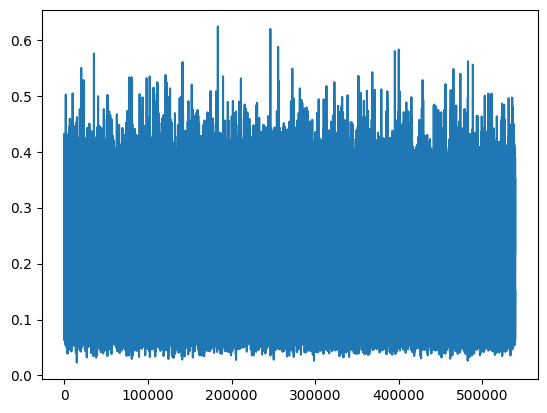

In [93]:
loader = DataLoader(TensorDataset(X,y), batch_size=64, shuffle=True)


losses = []
for i in tqdm(range(300)):
    for Xi,yi in loader:
        Xi,yi = Xi.to(DEVICE), yi.to(DEVICE)
        logits = model(Xi)
        loss = criterion(logits, yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.plot(losses)

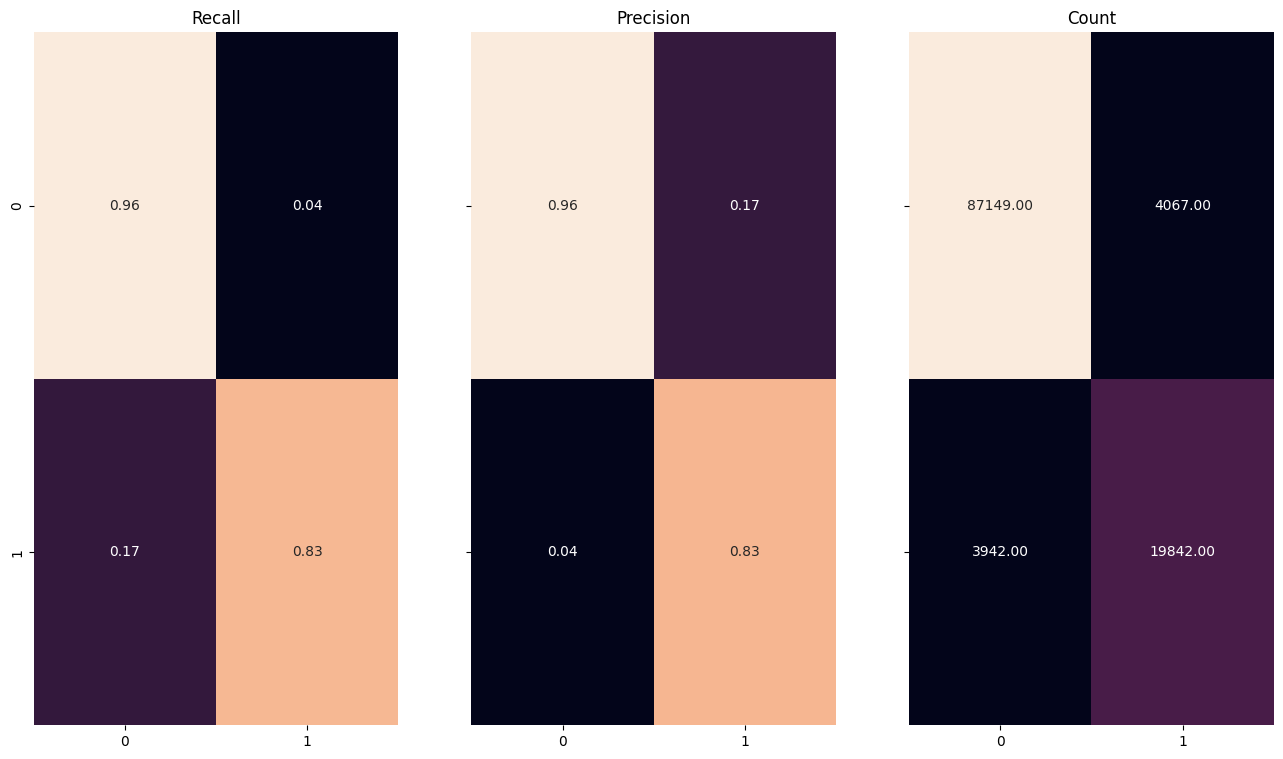

In [94]:
y_true, y_pred, loss, prec, recall, f1_score = evaluate_loop(model, criterion, loader, DEVICE, metrics=True)
plot_and_save_cm(y_true, y_pred)
print(loss, prec, recall, f1_score)